# Prediction of paper machine failure
Dataset obtained from the paper: "Dataset: Rare Event Classification in Multivariate Time Series". Basic info about dataset:
- 18393 records
- y = binary response, only 124 occurences
- x1 - x61 = predictors; x61 is binary variable, x28 is categorical variable
- all predictors are centered (mean is substracted from them)
- the predictors are a mixture of raw materials and process variables

Techniques used in this notebook:
- feature engineering proposed by mentioned paper (first and second difference of predictors, x28 change)
- SMOTE oversampling
- feature selection methods (L1 regularization, correlation with response)
- dimensionality reduction using PCA

In [89]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib as mpl
import numpy as np
data = pd.read_csv('rare-event-mts-data.csv')

In [90]:
# define time as time variable
data['time'] = pd.to_datetime(data['time'])
print('The date range:', data['time'].min(), 'to', data['time'].max())

The date range: 1999-05-01 00:00:00 to 1999-05-29 00:06:00


In [91]:
data.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,1999-05-01 00:00:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,1999-05-01 00:02:00,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,1999-05-01 00:04:00,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,1999-05-01 00:06:00,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,1999-05-01 00:08:00,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


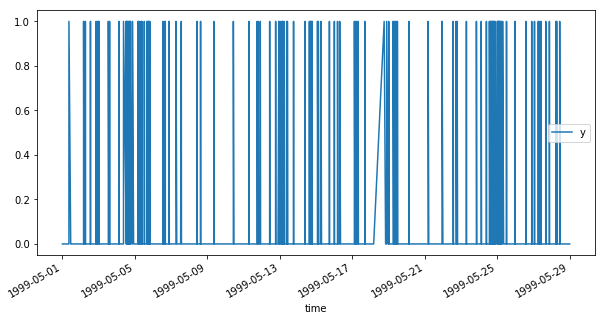

In [92]:
data.plot(x='time', y='y', figsize=(10,5));

In [93]:
def first_diff(x):
    first_diff = x - x.shift(1)
    return(first_diff)

In [94]:
def second_diff(x):
    first_diff = x - x.shift(1)
    second_diff = first_diff - first_diff.shift(1)
    return(second_diff)

In [95]:
# create second difference from variables x1 - x61 without x61 and x28
cols_to_remove = ['x28', 'x61', 'y', 'time']
cols = data.drop(cols_to_remove, inplace=False, axis=1).columns

data[cols].head()
data[cols].columns

import numpy as np

for col in cols:
    data.loc[:,col+"d1"] = first_diff(data[col])
    data.loc[:,col+"d2"] = second_diff(data[col])

In [96]:
print(data.columns)

Index(['time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       ...
       'x56d1', 'x56d2', 'x57d1', 'x57d2', 'x58d1', 'x58d2', 'x59d1', 'x59d2',
       'x60d1', 'x60d2'],
      dtype='object', length=181)


In [97]:
# create x28 change variable and drop x28d1
data['x28d1'] = data['x28'] - data['x28'].shift(1)
data['x28change'] = np.where((data['x28d1']==0) | (data['x28d1'].isna()), 0, 1)

In [98]:
# drop variable x28d1
data.drop('x28d1', axis=1, inplace=True)

In [99]:
# created lagged outcome variable - 1,2 periods - suggested by authors     
data['ylag1'] = data['y'].shift(1)
data['ylag2'] = data['y'].shift(2)

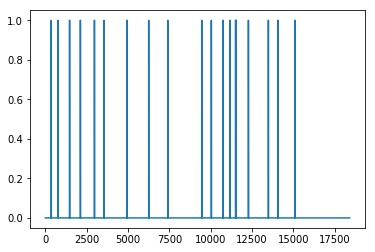

In [101]:
data['x28change'].plot();

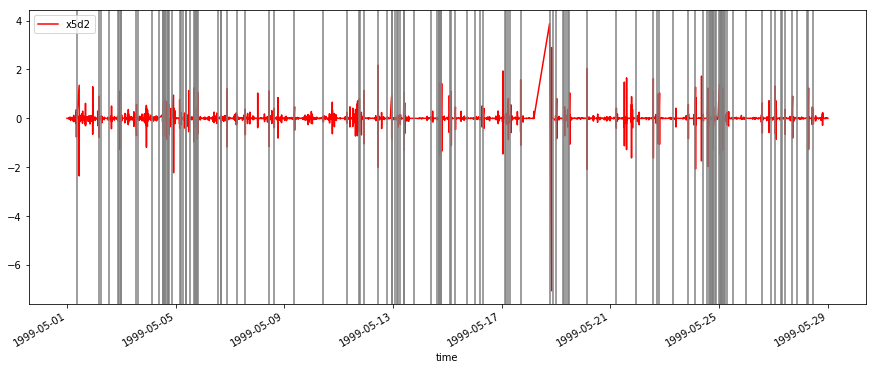

In [102]:
# target y vs. x5d2
import matplotlib.pyplot as plt
data.plot.line(x = 'time', y='x5d2', figsize=(15, 6), color='r')

xcoords = data[data["y"] == 1]['time']
for xc in xcoords:
    plt.axvline(x=xc, color='gray')

In [103]:
data.columns
data.iloc[:, 2:-2].head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x56d2,x57d1,x57d2,x58d1,x58d2,x59d1,x59d2,x60d1,x60d2,x28change
0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,...,NaN,-0.790467,NaN,0.000092,NaN,0.137283,NaN,0.000007,NaN,0
2,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,...,-0.000031,0.854554,1.645021,0.000093,0.000001,0.750038,0.612755,0.000007,0.000000e+00,0
3,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,...,-9.576812,0.448608,-0.405946,0.000092,-0.000001,0.714340,-0.035698,0.000007,0.000000e+00,0
4,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,...,5.567016,-0.384522,-0.833130,0.000056,-0.000036,-1.144386,-1.858726,0.000008,1.000000e-06,0


# All variables, original class distribution

## 1) remove predictors with correlation higher than 0.5

In [104]:
# multicollinearity check
corr_matrix = data.iloc[:, 2:-2].corr()[data.iloc[:, 2:-2].corr()>0.5].abs()

corr_matrix_unstacked = corr_matrix.unstack()

pairs = corr_matrix_unstacked.sort_values(kind="quicksort")
pairs = pairs.drop_duplicates()

# remove NaN and corr=1 rows
pairs = pairs[(pairs.isna()==False) & (pairs[pairs<1])]

vars_remove = []
vars_remained = []
for i in range(len(pairs)):
    if data.corr()['ylag2'][pairs.index[i][0]] < data.corr()['ylag2'][pairs.index[i][1]]:
        var_remove = pairs.index[i][0]
        vars_remove.append(var_remove)
    else:
        var_remove = pairs.index[i][1]
        vars_remove.append(var_remove)  
        
print('Variables to remove:', set(vars_remove))  
print(len(set(vars_remove)), 'variables were removed.')

vars_remained = list(set(data.iloc[:, 2:-2].columns) - set(vars_remove))
print('Variables remained:', vars_remained)  
print(len(set(vars_remained)), 'variables remained in the data set.')

Variables to remove: {'x36d2', 'x18d2', 'x53d2', 'x32', 'x44d2', 'x51', 'x38', 'x16d1', 'x51d1', 'x31d2', 'x19d2', 'x2d1', 'x22d2', 'x2d2', 'x7d1', 'x36', 'x38d1', 'x48d2', 'x29d1', 'x12d1', 'x60d2', 'x11', 'x29', 'x18', 'x6d1', 'x40d2', 'x52', 'x48d1', 'x15d1', 'x41d2', 'x13d1', 'x46d2', 'x50', 'x39d2', 'x34', 'x22', 'x22d1', 'x53', 'x46d1', 'x25d1', 'x27', 'x39', 'x9d2', 'x57d2', 'x23', 'x55d1', 'x16d2', 'x19', 'x52d2', 'x11d2', 'x37', 'x5d2', 'x31', 'x7d2', 'x49d1', 'x26', 'x54d2', 'x51d2', 'x42d2', 'x35', 'x6', 'x26d2', 'x58d1', 'x33', 'x23d1', 'x21d1', 'x56d1', 'x10d2', 'x14d1', 'x29d2', 'x11d1', 'x59d1', 'x25d2', 'x12', 'x30d1', 'x47', 'x37d2', 'x24d1', 'x43d2', 'x37d1', 'x17d2', 'x40', 'x50d2', 'x25', 'x16', 'x35d1', 'x1d1', 'x23d2', 'x1d2', 'x20d1', 'x41d1', 'x38d2', 'x17', 'x8d2', 'x34d1', 'x30', 'x13', 'x54', 'x47d1', 'x32d1', 'x4d1', 'x10d1', 'x33d1', 'x59d2', 'x56d2', 'x45d2', 'x3', 'x10', 'x8d1', 'x24d2', 'x44', 'x32d2', 'x59', 'x3d2', 'x6d2', 'x27d1', 'x12d2'}
117 variabl

**Divide dataset into training and testing based on time: train = 01/05/99 - 21/5/99, test = 22/5/99 - 98/5/99**

In [105]:
# drop rows with na from data frame 'data'
data.dropna(inplace=True)

# y shifted 2 periods back
X, y = data[vars_remained].values, data.iloc[:, -1].values

train_to = round(len(X)*0.8)

X_train = X[:train_to,]
y_train = y[:train_to]

X_test = X[train_to:, ]
y_test = y[train_to:]

## Logistic regression, random forest, gradient boosting

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()
gb = GradientBoostingClassifier()

                     precision    recall  matthews
model                                             
gradient boosting     0.394698  0.385000  0.357956
logistic regression   0.404762  0.116667  0.203216
random forest         0.766667  0.226667  0.406695
                     precision    recall  matthews
model                                             
gradient boosting     0.314046  0.274389  0.244018
logistic regression   0.473804  0.111803  0.216477
random forest         0.416905  0.141253  0.224047


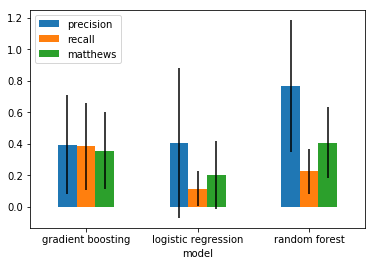

In [107]:
SKfold_prec_recall(X_train, y_train, models=[lr, rf, gb])

## 2) Feature selection based on L1 regularization for logistic regression

In [108]:
# start with all variables
# drop rows with na from data frame 'data'
data.dropna(inplace=True)

# y shifted 2 periods back
X, y = data.iloc[:, 2:-2].values, data.iloc[:, -1].values

train_to = round(len(X)*0.8)

X_train = X[:train_to,]
y_train = y[:train_to]

X_test = X[train_to:, ]
y_test = y[train_to:]

In [109]:
from sklearn.linear_model import LogisticRegression
lr_l1 = LogisticRegression(penalty='l1')
lr_l1.fit(X_train, y_train)
print(lr_l1.coef_[lr_l1.coef_ > 0].shape[0], 'variables out of', lr_l1.coef_.shape[1], 'remained.')

44 variables out of 180 remained.


In [110]:
# features selected by L1 regularization
all_predictors = np.array(data.columns[2:-2])
stay = np.array(lr_l1.coef_ > 0)[0]
data[all_predictors[stay]].head()
np.append(all_predictors[stay], 'ylag2')
data[np.append(all_predictors[stay], 'ylag2')].head()

,x4,x5,x12,x13,x17,x19,x20,x23,x24,x27,...,x35d2,x42d1,x44d1,x44d2,x45d1,x46d1,x47d1,x51d2,x56d2,ylag2
2,14.127998,-0.138636,0.065150,-9.619596,-2.353925,3.075199,0.123154,-9.784456,0.364356,-0.097144,...,0.419505,1.502556,-2.25586,-21.00195,0.837853,0.606278,-0.23761,0.0,-0.000031,0.0
3,13.161567,-0.148142,-0.067199,-15.196531,-2.367223,3.075199,0.123154,-9.784456,0.368556,-0.160073,...,0.000005,1.502548,-2.43164,-0.17578,-0.949635,1.194065,-0.47619,0.0,-9.576812,0.0
4,15.267340,-0.155314,-0.018472,-14.609266,-2.380521,3.075199,0.123154,-9.784456,0.372756,-0.131630,...,-0.000001,1.502556,-2.43359,-0.00195,0.748966,-0.737568,-0.47614,0.0,5.567016,0.0
5,14.143195,-0.162501,-0.093183,-12.999540,-2.393815,3.075199,0.123154,-9.784456,0.376956,-0.133819,...,-4.032863,1.502548,-2.43164,0.00195,0.261605,-0.470047,-0.47613,0.0,1.170837,0.0
6,18.681465,-0.169672,-0.138765,-10.783887,-2.407113,3.075199,0.123154,-9.784456,0.381156,-0.150353,...,4.041393,-1.451767,3.42187,5.85351,-0.785141,0.908413,-0.47614,0.0,-0.000029,0.0


In [111]:
# divide into training and testing data set and remain only variables selected by L1
# drop rows with na from data frame 'data'
data2 = data[np.append(all_predictors[stay], 'ylag2')]
data2.dropna(inplace=True)
data2.iloc[:, :-1].head()
data2.iloc[:, -1].head()

X, y = data2.iloc[:, :-1].values, data2.iloc[:, -1].values

train_to = round(len(X)*0.8)

X_train = X[:train_to,]
y_train = y[:train_to]

X_test = X[train_to:, ]
y_test = y[train_to:]

In [112]:
# initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()
gb = GradientBoostingClassifier()

                     precision    recall  matthews
model                                             
gradient boosting     0.325322  0.267500  0.265890
logistic regression   0.096194  0.232353  0.066629
random forest         0.641026  0.192308  0.337030
                     precision    recall  matthews
model                                             
gradient boosting     0.340106  0.231286  0.244128
logistic regression   0.261918  0.301528  0.190338
random forest         0.480384  0.184669  0.270615


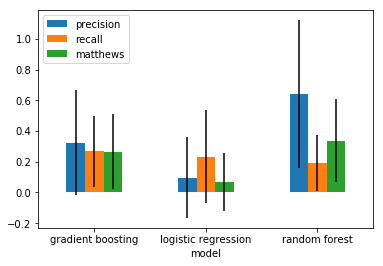

In [113]:
SKfold_prec_recall(X_train, y_train, models=[lr, rf, gb])

## 3) top 20 variables with highest correlation to ylag2
### variables with correlation higher than 0.5 between each other removed

In [122]:
# select top 20 variables most correlated with ylag2
top20vars = data.corr()['ylag2'].abs().sort_values(ascending=False)[1:21].index

# multicollinearity check
corr_matrix = data[top20vars].corr()[data[top20vars].corr()>0.5].abs()

corr_matrix_unstacked = corr_matrix.unstack()

pairs = corr_matrix_unstacked.sort_values(kind="quicksort")
pairs = pairs.drop_duplicates()

# remove NaN and corr=1 rows
pairs = pairs[(pairs.isna()==False) & (pairs[pairs<1])]

vars_remove_y = []
for i in range(len(pairs)):
    if data.corr()['ylag2'][pairs.index[i][0]] < data.corr()['ylag2'][pairs.index[i][1]]:
        var_remove_y = pairs.index[i][0]
        vars_remove_y.append(var_remove_y)
    else:
        var_remove_y = pairs.index[i][1]
        vars_remove_y.append(var_remove_y)  
print('Variables to remove:', vars_remove_y)    

vars_remained_y = list(set(list(top20vars)) - set(vars_remove_y))
print('Variables remained:', vars_remained_y)

Variables to remove: ['x10', 'x56d2', 'x22d2', 'x18d2', 'x38', 'x18d2', 'x38d1', 'x3d2']
Variables remained: ['x42', 'x48d2', 'x34d2', 'x9d1', 'x17d2', 'x42d2', 'x5d2', 'x19d2', 'x15d2', 'x9', 'x50d2', 'x2d2', 'x13d2']


In [123]:
# drop rows with na from data frame 'data'
data.dropna(inplace=True)

# make X and y data set
X, y = data[vars_remained_y].values, data.iloc[:, -1].values

train_to = round(len(X)*0.8)

X_train = X[:train_to,]
y_train = y[:train_to]

X_test = X[train_to:, ]
y_test = y[train_to:]

In [124]:
# initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()
gb = GradientBoostingClassifier()

                     precision    recall  matthews
model                                             
gradient boosting     0.767468  0.560000  0.618984
logistic regression   0.789474  0.371053  0.521819
random forest         0.956140  0.555263  0.707176
                     precision    recall  matthews
model                                             
gradient boosting     0.244574  0.284975  0.188797
logistic regression   0.297064  0.234115  0.221966
random forest         0.105294  0.235050  0.146892


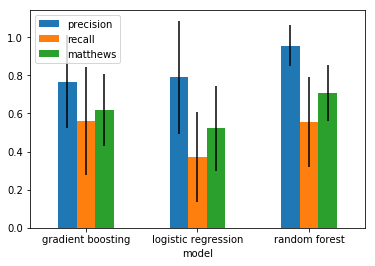

In [125]:
SKfold_prec_recall(X_train, y_train, models=[lr, rf, gb])

## 4) Dimension reduction - PCA
### Continue with variables selected by correlation with response

In [126]:
# standardize variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

# principle components analysis
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.15291371, 0.14938779, 0.09935   , 0.09271449, 0.08203601,
       0.07692948, 0.06168572, 0.06019461, 0.05895295, 0.0471305 ,
       0.04416531, 0.0403946 , 0.03414483])

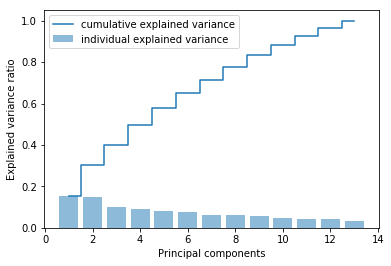

In [127]:
import matplotlib.pyplot as plt
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='left left')
plt.show()

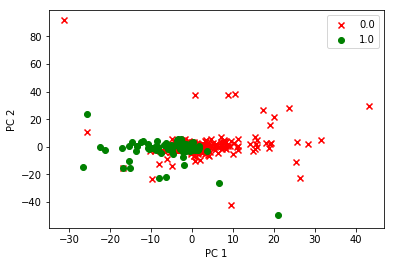

In [128]:
colors = ['r', 'g']
markers = ['x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper right');

In [129]:
# use 8 principal components - they cover 80 % of variance
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [130]:
# initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()
gb = GradientBoostingClassifier()

                     precision    recall  matthews
model                                             
gradient boosting     0.516040  0.357895  0.405980
logistic regression   0.685294  0.373529  0.475209
random forest         0.711376  0.391667  0.502345
                     precision    recall  matthews
model                                             
gradient boosting     0.276295  0.233490  0.192018
logistic regression   0.346354  0.272785  0.232846
random forest         0.384740  0.297168  0.283222


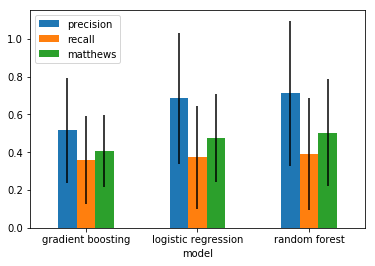

In [131]:
SKfold_prec_recall(X_train_pca, y_train, models=[lr, rf, gb])

# Class balancing - oversampling using SMOTE

## In cross-validation, oversample only folds used for training, not for testing!!!
### Approach based on L1 regularization not tested here because of latter bad performance 

## 1) All variables without correlated ones

In [132]:
# drop rows with na from data frame 'data'
data.dropna(inplace=True)

# y shifted 2 periods back
X, y = data[vars_remained].values, data.iloc[:, -1].values

train_to = round(len(X)*0.8)

X_train = X[:train_to,]
y_train = y[:train_to]

X_test = X[train_to:, ]
y_test = y[train_to:]

In [133]:
# initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()
gb = GradientBoostingClassifier()

                     precision  recall  matthews
model                                           
gradient boosting     0.434616  0.7250  0.521710
logistic regression   0.032866  0.5775  0.085226
random forest         0.864444  0.3700  0.549430
                     precision    recall  matthews
model                                             
gradient boosting     0.296217  0.207428  0.199461
logistic regression   0.054556  0.257761  0.098911
random forest         0.283534  0.202485  0.208415


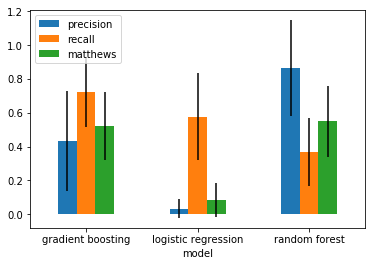

In [134]:
SKfold_prec_recall_SMOTE(X_train, y_train, models=[gb, lr, rf])

## 2) Variables with highest correlation to response

In [135]:
# drop rows with na from data frame 'data'
data.dropna(inplace=True)

# make X and y data set
X, y = data[vars_remained_y].values, data.iloc[:, -1].values

train_to = round(len(X)*0.8)

X_train = X[:train_to,]
y_train = y[:train_to]

X_test = X[train_to:, ]
y_test = y[train_to:]

In [136]:
# initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()
gb = GradientBoostingClassifier()

                     precision  recall  matthews
model                                           
gradient boosting     0.494048  0.7475  0.592834
logistic regression   0.134178  0.6775  0.278953
random forest         0.861071  0.6825  0.750056
                     precision    recall  matthews
model                                             
gradient boosting     0.177394  0.218533  0.158043
logistic regression   0.092291  0.284455  0.149588
random forest         0.184031  0.217204  0.151981


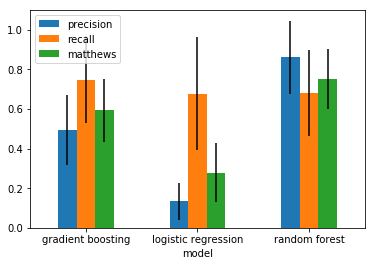

In [137]:
SKfold_prec_recall_SMOTE(X_train, y_train, models=[gb, lr, rf])

# 3) PCA

                     precision  recall  matthews
model                                           
gradient boosting     0.092345  0.6625  0.230429
logistic regression   0.079858  0.6925  0.213733
random forest         0.305232  0.5625  0.396397
                     precision    recall  matthews
model                                             
gradient boosting     0.059223  0.214522  0.100721
logistic regression   0.054693  0.286666  0.113287
random forest         0.164695  0.242723  0.176665


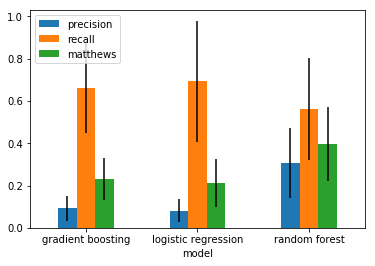

In [138]:
SKfold_prec_recall_SMOTE(X_train_pca, y_train, models=[lr, rf, gb])

# Performance on test set - features selected based on correlation with ylag2

## Original class distribution

In [139]:
# drop rows with na from data frame 'data'
data.dropna(inplace=True)

# make X and y data set
X, y = data[vars_remained_y].values, data.iloc[:, -1].values

train_to = round(len(X)*0.5)

X_train = X[:train_to,]
y_train = y[:train_to]

X_test = X[train_to:, ]
y_test = y[train_to:]

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

lr = LogisticRegression()
lr.fit(X_train, y_train)

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [141]:
models = [rf, lr, gb]

for model in models:
    print(model.__class__.__name__)
    print(perf_metrics(model, X_test, y_test))
    print('')

RandomForestClassifier
col_0   0.0  1.0
row_0           
0.0    9133   31
1.0       3   31
Sensitivity = 0.5
Precision = 0.9117647058823529
Matthews correlation = 0.6738560087598862
None

LogisticRegression
col_0   0.0  1.0
row_0           
0.0    9110   41
1.0      26   21
Sensitivity = 0.3387096774193548
Precision = 0.44680851063829785
Matthews correlation = 0.38746140677369506
None

GradientBoostingClassifier
col_0   0.0  1.0
row_0           
0.0    9108   29
1.0      28   33
Sensitivity = 0.532258064516129
Precision = 0.5409836065573771
Matthews correlation = 0.5348277990345476
None



## SMOTE

In [142]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_sm, y_train_sm)

lr = LogisticRegression()
lr.fit(X_train_sm, y_train_sm)

gb = GradientBoostingClassifier()
gb.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [144]:
models = [rf, lr, gb]

for model in models:
    print(model.__class__.__name__)
    print(perf_metrics(model, X_test, y_test))
    print('')

RandomForestClassifier
col_0   0.0  1.0
row_0           
0.0    9117   12
1.0      19   50
Sensitivity = 0.8064516129032258
Precision = 0.7246376811594203
Matthews correlation = 0.7631016364768815
None

LogisticRegression
col_0   0.0  1.0
row_0           
0.0    7501   16
1.0    1635   46
Sensitivity = 0.7419354838709677
Precision = 0.027364663890541343
Matthews correlation = 0.12835534113473243
None

GradientBoostingClassifier
col_0   0.0  1.0
row_0           
0.0    9070    7
1.0      66   55
Sensitivity = 0.8870967741935484
Precision = 0.45454545454545453
Matthews correlation = 0.6323662390724312
None



# Functions used throughout the notebook

In [88]:
def SKfold_prec_recall_SMOTE(X_train, y_train, models):

    import numpy as np
    import matplotlib.pyplot as plt

    from sklearn.model_selection import StratifiedKFold
    from imblearn.over_sampling import SMOTE
    from sklearn.metrics import matthews_corrcoef

    kfold = StratifiedKFold(n_splits=20, random_state=1).split(X_train, y_train)
    sm = SMOTE(random_state=12)
    
    precisions = []
    recalls = []
    classifiers = []
    matthews = []

    for k, (train, test) in enumerate(kfold):
       
        X_train_sm, y_train_sm = sm.fit_sample(X_train[train], y_train[train])

        for model in models:
            
            model.fit(X_train_sm, y_train_sm)

            predictions = model.predict(X_train[test])

            if len(np.unique(predictions)) > 1:   

                TP = pd.crosstab(predictions, y_train[test])[1][1]
                FN = pd.crosstab(predictions, y_train[test])[1][0]
                TN = pd.crosstab(predictions, y_train[test])[0][0]
                FP = pd.crosstab(predictions, y_train[test])[0][1]
                
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)

                matthew = matthews_corrcoef(y_train[test], predictions) 
                
                if model == lr:
                    classifiers.append('logistic regression')
                elif model == rf:
                    classifiers.append('random forest')
                else:
                    classifiers.append('gradient boosting')         

                precisions.append(precision)
                recalls.append(recall)

                matthews.append(matthew)

    d = {'precision': precisions, 'recall': recalls, 'matthews': matthews, 'model': classifiers}
    df = pd.DataFrame(d)
    
    means = df.groupby(['model'])['precision', 'recall', 'matthews'].mean()
    errors = df.groupby(['model'])['precision', 'recall', 'matthews'].std()
    
    fig, ax = plt.subplots()
    means.plot.bar(yerr=errors, ax=ax, rot=0)
    plt.legend(loc=2)
    
    print(means)
    print(errors)

In [87]:
def SKfold_prec_recall(X_train, y_train, models):

    import numpy as np
    import matplotlib.pyplot as plt

    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import matthews_corrcoef

    kfold = StratifiedKFold(n_splits=20, random_state=1).split(X_train, y_train)

    precisions = []
    recalls = []
    classifiers = []
    matthews = []

    for k, (train, test) in enumerate(kfold):

        for model in models:

            model.fit(X_train[train], y_train[train])

            predictions = model.predict(X_train[test])

            if len(np.unique(predictions)) > 1:   

                TP = pd.crosstab(predictions, y_train[test])[1][1]
                FN = pd.crosstab(predictions, y_train[test])[1][0]
                TN = pd.crosstab(predictions, y_train[test])[0][0]
                FP = pd.crosstab(predictions, y_train[test])[0][1]
                
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                
                matthew = matthews_corrcoef(y_train[test], predictions) 

                if model == lr:
                    classifiers.append('logistic regression')
                elif model == rf:
                    classifiers.append('random forest')
                else:
                    classifiers.append('gradient boosting')         

                precisions.append(precision)
                recalls.append(recall)
                
                matthews.append(matthew)

    d = {'precision': precisions, 'recall': recalls, 'matthews': matthews, 'model': classifiers}
    df = pd.DataFrame(d)
    
    means = df.groupby(['model'])['precision', 'recall', 'matthews'].mean()
    errors = df.groupby(['model'])['precision', 'recall', 'matthews'].std()
    
    fig, ax = plt.subplots()
    means.plot.bar(yerr=errors, ax=ax, rot=0)
    plt.legend(loc=2)
    
    print(means)
    print(errors)

In [86]:
# function for computation of sensitivity and precision
def perf_metrics(model, X, Y):
    
    import numpy as np
    from math import sqrt
    #from sklearn.metrics import matthews_corrcoef
    
    predictions = model.predict(X)
    
    if len(np.unique(predictions)) == 1:
        print('There is only one class predicted by model.')
    else:
        TP = pd.crosstab(predictions, Y)[1][1]
        FN = pd.crosstab(predictions, Y)[1][0]
        TN = pd.crosstab(predictions, Y)[0][0]
        FP = pd.crosstab(predictions, Y)[0][1]

        sensitivity = TP/(TP+FN)
        precision = TP/(TP+FP)
        
        matthew_formula = (TP*TN-FP-FN)/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        
        #matthew = matthews_corrcoef(Y, predictions) 
     
        print(pd.crosstab(predictions, Y))
        print('Sensitivity =', sensitivity)
        print('Precision =', precision)
        print('Matthews correlation =', matthew_formula)
        #print('Matthews correlation =', matthew)